# Logistic Regression

In [6]:
# Core
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve
)
from sklearn.preprocessing import StandardScaler



In [2]:
# Carga de particiones ya preparadas
train_under = pd.read_csv("../data/bogie_train_under_1a5.csv")
valid       = pd.read_csv("../data/bogie_valid.csv")
test        = pd.read_csv("../data/bogie_test.csv")

In [3]:
# Columnas que NO entran como features
cols_to_exclude = [
    "timestamp",
    "train_id",
    "bogie_id",
    "target_fault",   # objetivo
    "alarm_level",    # pseudo-target
    "fault_type"      # pseudo-target
]

all_cols = train_under.columns.tolist()
feature_cols = [c for c in all_cols if c not in cols_to_exclude]

print("Nº de features:", len(feature_cols))

X_train = train_under[feature_cols].copy()
y_train = train_under["target_fault"].copy()

X_valid = valid[feature_cols].copy()
y_valid = valid["target_fault"].copy()


Nº de features: 28


In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)


In [7]:
log_reg = LogisticRegression(
    penalty="l2",        # regularización ridge
    C=1.0,               # inverso de la fuerza de regularización
    class_weight="balanced",
    solver="lbfgs",
    max_iter=500,
    n_jobs=-1
)

log_reg.fit(X_train_scaled, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,500
,multi_class,'deprecated'


In [8]:
y_valid_proba = log_reg.predict_proba(X_valid_scaled)[:, 1]
y_valid_pred  = log_reg.predict(X_valid_scaled)

cm = confusion_matrix(y_valid, y_valid_pred)
roc = roc_auc_score(y_valid, y_valid_proba)
pr_auc = average_precision_score(y_valid, y_valid_proba)

print("Matriz de confusión (valid):\n", cm)
print("\nROC-AUC (valid):", roc)
print("PR-AUC  (valid):", pr_auc)
print("\nInforme clasificación (valid):")
print(classification_report(y_valid, y_valid_pred, digits=3))



Matriz de confusión (valid):
 [[15001 13926]
 [  216   230]]

ROC-AUC (valid): 0.5093301973531331
PR-AUC  (valid): 0.015385656071431986

Informe clasificación (valid):
              precision    recall  f1-score   support

         0.0      0.986     0.519     0.680     28927
         1.0      0.016     0.516     0.032       446

    accuracy                          0.519     29373
   macro avg      0.501     0.517     0.356     29373
weighted avg      0.971     0.519     0.670     29373



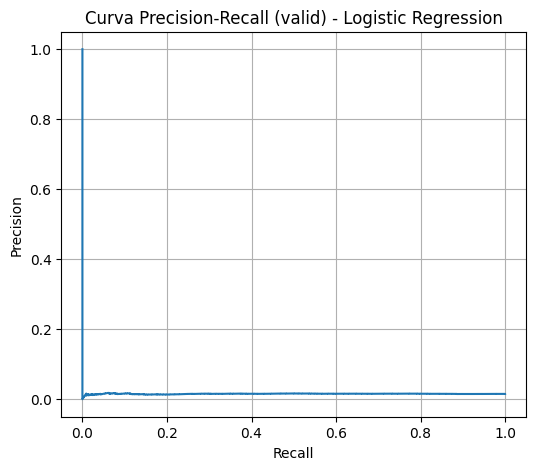

In [9]:
precision, recall, thresholds = precision_recall_curve(y_valid, y_valid_proba)

plt.figure(figsize=(6,5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall (valid) - Logistic Regression")
plt.grid(True)
plt.show()

### Evaluación del modelo de Regresión Logística

- En el conjunto de validación, la regresión logística identifica aproximadamente la mitad de los fallos reales (recall de la clase 1 ≈ 0,52), pero a costa de generar un número muy elevado de falsos positivos: casi la mitad de los ejemplos sin fallo son clasificados erróneamente como fallo.

- La precisión de la clase 1 es muy baja (≈ 1,6 %): de cada 100 alertas generadas por el modelo, solo 1–2 corresponden realmente a un fallo. Esto haría que el sistema de mantenimiento se viera saturado de falsas alarmas y reduciría drásticamente la utilidad práctica del modelo.

- Las métricas agregadas ROC-AUC (~0,51) y PR-AUC (~0,015) están muy próximas al comportamiento aleatorio, lo que indica que el ranking de probabilidades que produce el modelo apenas separa los casos con fallo de los casos sin fallo.

- En resumen, aunque la regresión logística consigue aumentar el recall respecto a otros modelos probados, lo hace a costa de una precisión extremadamente baja y sin mejorar de forma significativa las métricas globales. Por tanto, este modelo no es adecuado como solución final y se considera solo como un experimento de referencia dentro del conjunto de modelos evaluados.
